In [1]:
# ============================================================
# 0) 依存関係（必要なら一度だけ実行）
# ============================================================
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler

from alibi_detect.cd import MMDDriftOnline


In [2]:
# ============================================================
# ① データの読み込み（N×M、df形式、学習とテストは別）
# ============================================================
def load_csv_df(path, sep=";", encoding="utf-8"):
    return pd.read_csv(path, sep=sep, encoding=encoding)
SEP = ","
train_csv_path = r".\\data\test_5\\SKAB\\X_train.csv"
test_csv_path  = r".\\data\test_5\\SKAB\\X_test.csv"
df_train = load_csv_df(train_csv_path, sep=SEP)
df_test  = load_csv_df(test_csv_path,  sep=SEP)

print("df_train shape:", df_train.shape)
print("df_test  shape:", df_test.shape)


df_train shape: (5643, 8)
df_test  shape: (41163, 8)


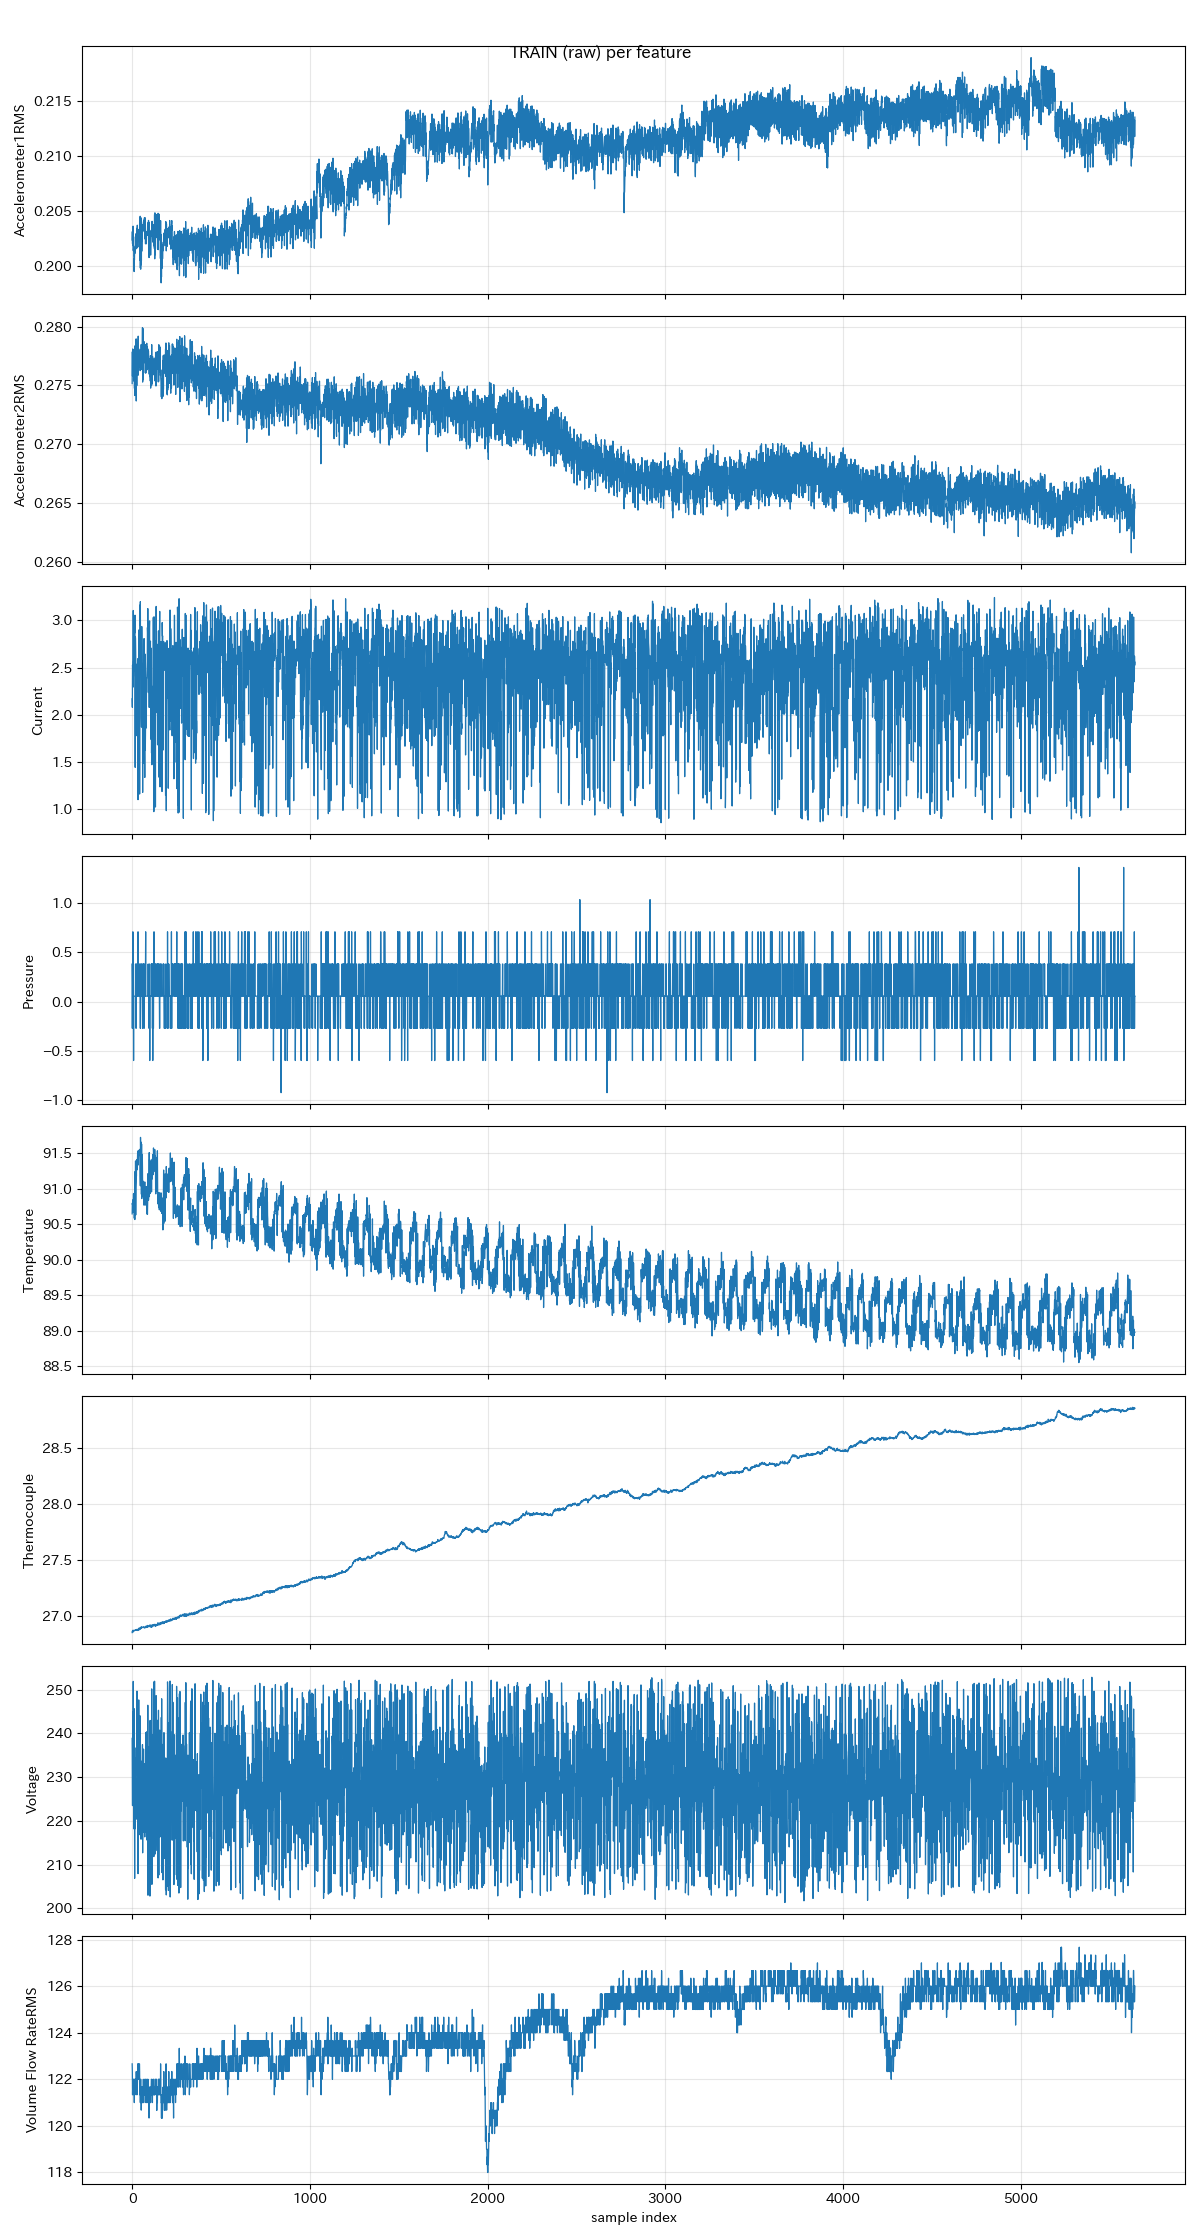

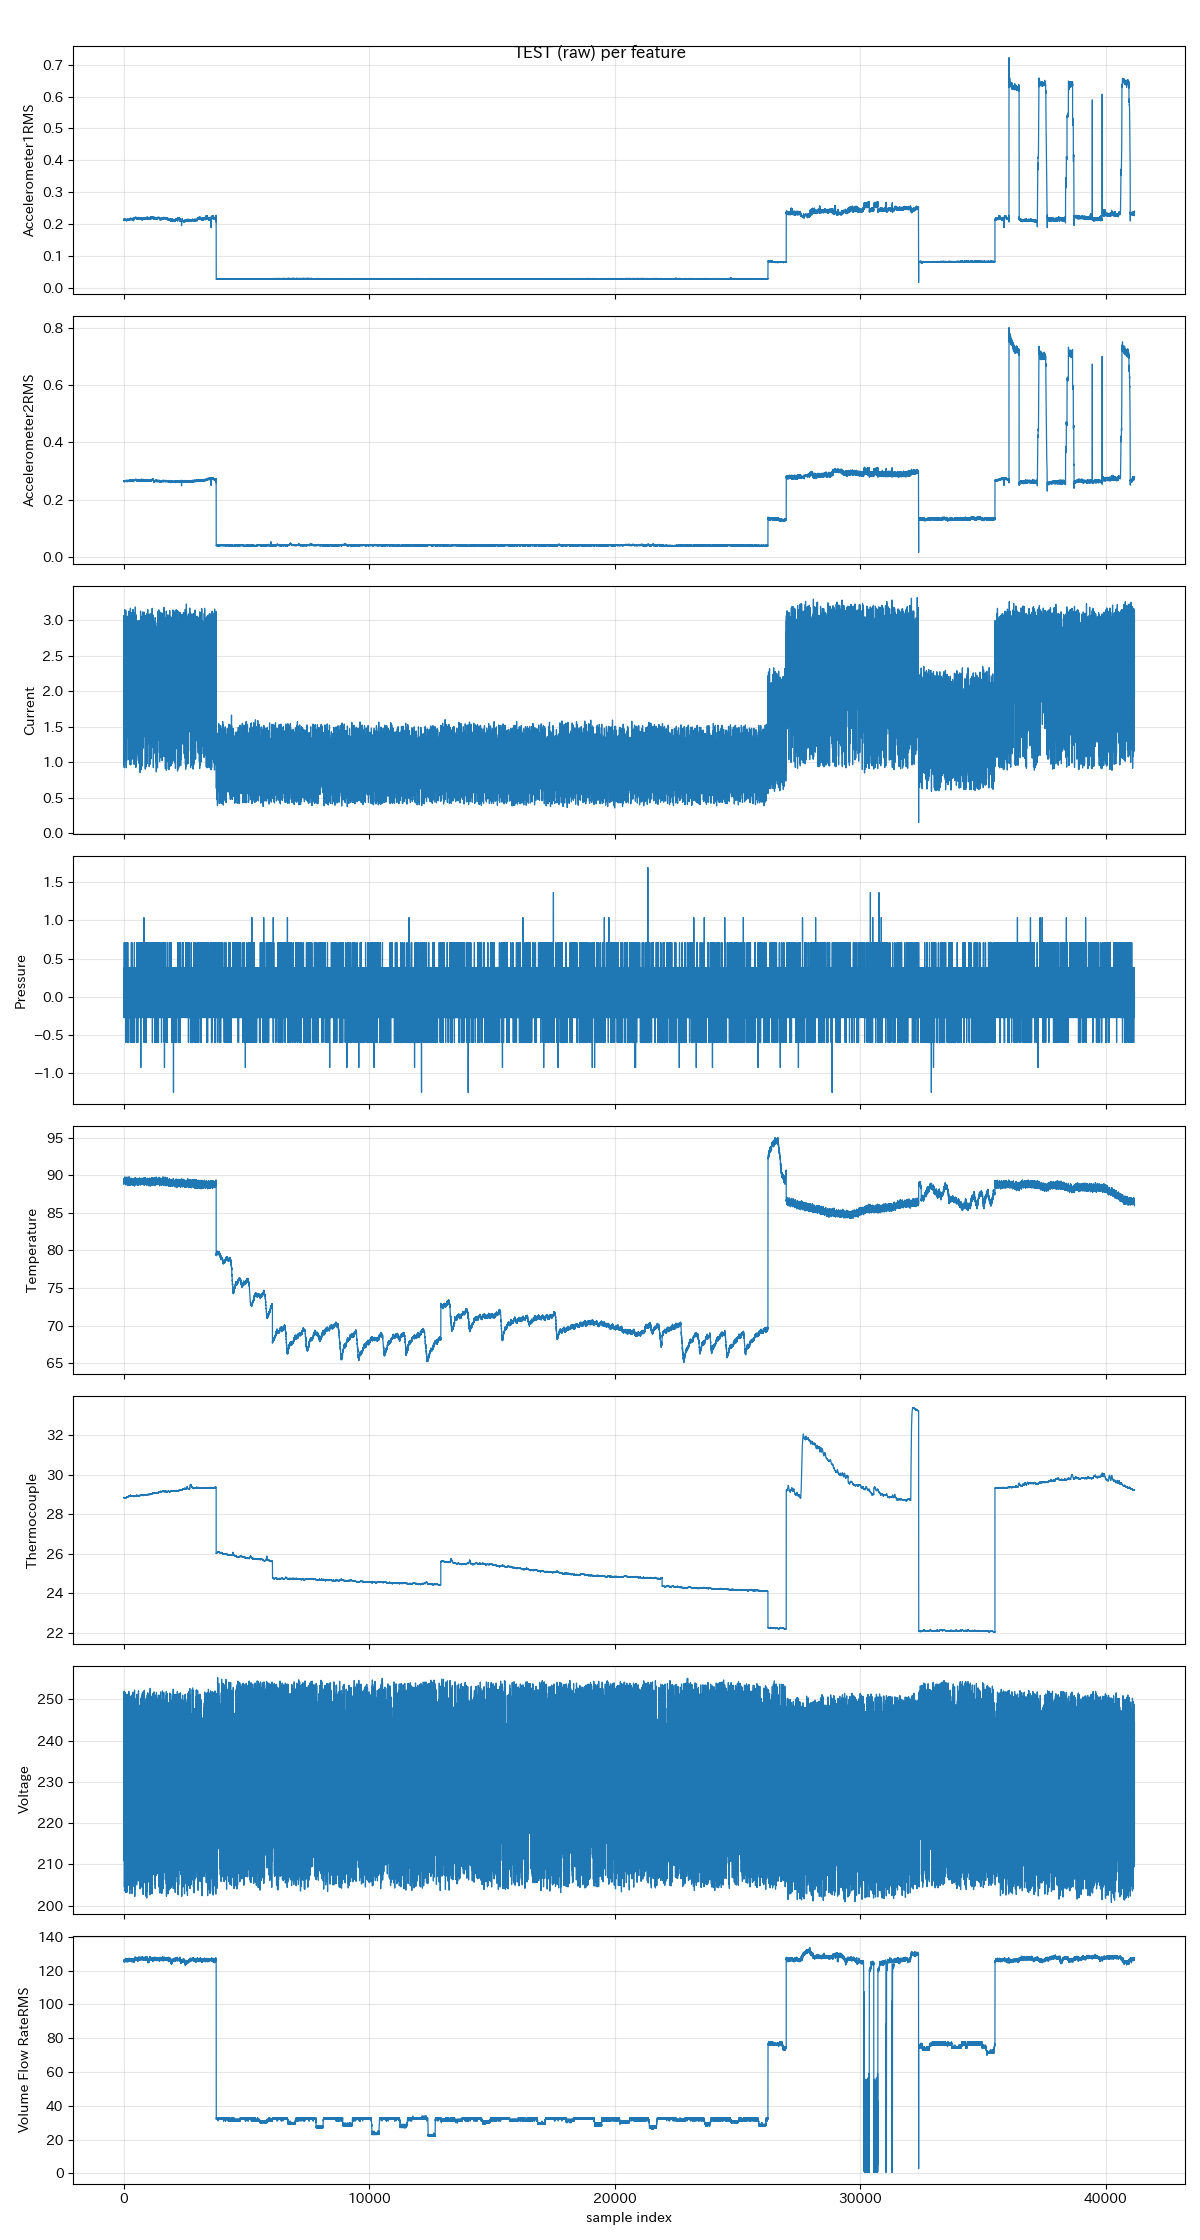

In [3]:

# ============================================================
# ② 読み込んだあとにデータを可視化（列ごとに時系列波形）
# ============================================================
def plot_timeseries_per_col(df, cols, title):
    n = len(cols)
    fig, axes = plt.subplots(n, 1, figsize=(12, 2.8*n), sharex=True)
    if n == 1:
        axes = [axes]
    x = np.arange(len(df))
    for ax, c in zip(axes, cols):
        ax.plot(x, df[c].values, linewidth=0.9)
        ax.set_ylabel(c)
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel("sample index")
    fig.suptitle(title)
    plt.tight_layout()

feature_cols_auto = [c for c in df_train.columns if pd.api.types.is_numeric_dtype(df_train[c])]
# 今回は f1,f2 だけだが、実データでも「数値列だけ自動抽出」→後で選別できる
plot_timeseries_per_col(df_train, feature_cols_auto, "TRAIN (raw) per feature")
plot_timeseries_per_col(df_test,  [c for c in feature_cols_auto if c in df_test.columns], "TEST (raw) per feature")


In [4]:
print(df_test.columns.tolist())

['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ============================================================
# 設定（ここだけ触ればOK）
# ============================================================
feature_cols = ["Current"]   # 周期性がありそうな列（複数でもOK）
CYCLE_LEN = 40              # 1周期が何点か（例：100点周期なら100）
MODE = "raw"                 # "raw" or "fft"
FFT_K = 20                   # MODE="fft" のとき、DC除外後に何個の周波数成分を使うか
PER_CYCLE_NORM = False       # Trueにすると「周期ごとに平均0・標準偏差1」で形だけを見やすくする

# ============================================================
# 周期ごとにサンプル化して特徴行列を作る関数
#   入力: df（N×Mの時系列）, cols（使う列）, L（周期長）
#   出力: X_feat（C×D）, feature_names（D個の列名）
#     - C = floor(N / L)（端数は切り捨て）
#     - MODE="raw": 1周期( L×M ) をそのまま並べて D=L*M
#     - MODE="fft": 1周期にFFT -> 振幅 |FFT| の(1..K)を使って D=K*M（DC=0番は除外）
# ============================================================
def make_cycle_features(df: pd.DataFrame,
                        cols,
                        L: int,
                        mode: str = "raw",
                        fft_k: int = 20,
                        per_cycle_norm: bool = False):
    # 1) 数値化（文字が混じっていても NaN に落として補間）
    Xdf = df[cols].apply(pd.to_numeric, errors="coerce")
    Xdf = Xdf.interpolate(limit_direction="both")

    X = Xdf.to_numpy(dtype=float)          # (N, M)
    N, M = X.shape

    # 2) 周期で切り出し（端数は切り捨て）
    C = N // L
    if C == 0:
        raise ValueError(f"データ長N={N}が周期長L={L}より短いので周期化できません。")
    Xc = X[:C*L].reshape(C, L, M)          # (C, L, M)

    # 3) （任意）周期ごとに正規化：形だけ比較したいときに使う
    #    - per_cycle_norm=True だと、各周期・各センサ列ごとに平均0・標準偏差1
    #    - 振幅の増加/減少も検知したい場合は False のままがよい
    if per_cycle_norm:
        mu = Xc.mean(axis=1, keepdims=True)
        sd = Xc.std(axis=1, keepdims=True) + 1e-12
        Xc = (Xc - mu) / sd

    # 4) 特徴化
    mode = mode.lower().strip()

    if mode == "raw":
        # 1周期(L×M)をそのまま横に並べる → (C, L*M)
        X_feat = Xc.reshape(C, L * M)

        # 列名：例 Current_t000 ... Current_t099（複数列なら列名×時刻）
        feature_names = []
        for m, col in enumerate(cols):
            for t in range(L):
                feature_names.append(f"{col}_t{t:03d}")

    elif mode == "fft":
        # FFT（周期内の時間軸=axis1） → rfft で片側スペクトル（0..L/2）
        F = np.fft.rfft(Xc, axis=1)        # (C, L//2+1, M)
        mag = np.abs(F)                    # 振幅（位相ズレに強くしたいならまずこれ）

        # DC(0番)は平均成分なので除外し、1..K を使う
        max_k = mag.shape[1] - 1           # DCを除いた最大個数
        k = int(min(fft_k, max_k))
        if k <= 0:
            raise ValueError(f"fft_k={fft_k} が小さすぎます。L={L} なら fft_k>=1 が必要です。")

        mag_sel = mag[:, 1:1+k, :]         # (C, k, M)
        X_feat = mag_sel.reshape(C, k * M) # (C, k*M)

        # 列名：例 Current_fft01 ... Current_fft20（複数列なら列名×周波数番号）
        feature_names = []
        for m, col in enumerate(cols):
            for i in range(1, 1+k):
                feature_names.append(f"{col}_fft{i:02d}")

    else:
        raise ValueError('mode は "raw" または "fft" を指定してください。')

    return X_feat, feature_names


# ============================================================
# 1) 周期ごとの特徴行列を作る（df_train, df_test は既にある前提）
# ============================================================
X_train_feat, feat_names = make_cycle_features(
    df_train, feature_cols, L=CYCLE_LEN, mode=MODE, fft_k=FFT_K, per_cycle_norm=PER_CYCLE_NORM
)
X_test_feat, _ = make_cycle_features(
    df_test, feature_cols, L=CYCLE_LEN, mode=MODE, fft_k=FFT_K, per_cycle_norm=PER_CYCLE_NORM
)

print("MODE:", MODE)
print("X_train_feat:", X_train_feat.shape, "  (rows=cycles, cols=features)")
print("X_test_feat :", X_test_feat.shape)

# （必要なら）DataFrame化して列名を付ける
X_train_df = pd.DataFrame(X_train_feat, columns=feat_names)
X_test_df  = pd.DataFrame(X_test_feat,  columns=feat_names)

# ============================================================
# 2) 標準化（周期特徴に対して、学習でfit→学習/テストへtransform）
# ============================================================
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_df.values)
X_test_std  = scaler.transform(X_test_df.values)

# ============================================================
# 3) 標準化結果の確認（プリント）
# ============================================================
print("\n=== After standardization (TRAIN) ===")
print("shape:", X_train_std.shape)
print("first 3 rows:\n", np.round(X_train_std[:3], 4))
print("mean per feature:", np.round(X_train_std.mean(axis=0)[:10], 6), " ...")
print("std  per feature :", np.round(X_train_std.std(axis=0, ddof=0)[:10], 6), " ...")

print("\n=== After standardization (TEST) ===")
print("shape:", X_test_std.shape)
print("first 3 rows:\n", np.round(X_test_std[:3], 4))
print("mean per feature (reference=TRAIN stats):", np.round(X_test_std.mean(axis=0)[:10], 6), " ...")
print("std  per feature (reference=TRAIN stats) :", np.round(X_test_std.std(axis=0, ddof=0)[:10], 6), " ...")

print("\n=== Scaler parameters (fitted on TRAIN) ===")
print("scaler.mean_ (first 10):", np.round(scaler.mean_[:10], 6), " ...")
print("scaler.scale_(first 10):", np.round(scaler.scale_[:10], 6), " ...")

# 以後、MMDDriftOnline には X_train_std / X_test_std を「1行=1周期」として流せる
# - window_size は「何周期分で窓を作るか」という意味になる



MODE: raw
X_train_feat: (141, 40)   (rows=cycles, cols=features)
X_test_feat : (1029, 40)

=== After standardization (TRAIN) ===
shape: (141, 40)
first 3 rows:
 [[-0.4371 -0.646   0.2232  0.2839 -0.2423  0.2978  1.4804 -0.0118  0.2471
   0.0796  1.2752  0.4733  0.9957  0.9263  1.0346  0.9936  1.3232 -1.7696
   0.7761  0.7822  0.3768  0.2017 -1.3351 -0.82    0.3235 -1.0984 -1.0767
  -0.7621  0.2235 -1.3673 -0.5708  0.3313 -0.2646 -2.6214  0.3915  0.4148
  -0.1193  0.9237  0.4918  1.0609]
 [ 0.3257  0.7595 -2.3777  0.7471  1.4879  1.1593  1.6676  0.7032  0.7422
   0.5187  0.8457 -1.0489 -1.1044 -1.0081  1.0981  0.6607 -0.3524  0.0112
   0.1534 -2.342  -0.8496 -0.1284 -1.0893 -1.1955 -0.4436 -0.9127 -1.1274
   0.8155 -1.7191 -1.1752 -1.5466 -2.1773  0.6272 -0.6476 -1.7097 -0.882
  -0.8756 -1.1309 -0.3856 -0.8202]
 [-0.6027  0.0222 -0.0362  0.1596  0.1565  0.2829  1.1187  0.9432  1.4572
   0.9559  1.0748 -0.4526  0.6733  0.5028  0.9568  0.1131 -0.9229  1.1231
   1.139  -0.0142 -0.0504  0.3

In [10]:

# ============================================================
# ④ MMDのモデル作成（MMDDriftOnline）
# 
# ============================================================

backend = "tensorflow"
# 参照分布（正常学習データから）
n_ref = 120
x_ref = X_train_std[:n_ref]

# パラメータ（まず動く値）
window_size = 10
ert = 100
n_bootstraps = 1000  # デモ用に軽め（安定させたいなら増やす）

cd = MMDDriftOnline(
    x_ref=x_ref,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    verbose=True
)



Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[TRAIN check] ratio(test_stat<=threshold)=0.810, false_alarm_rate=0.190


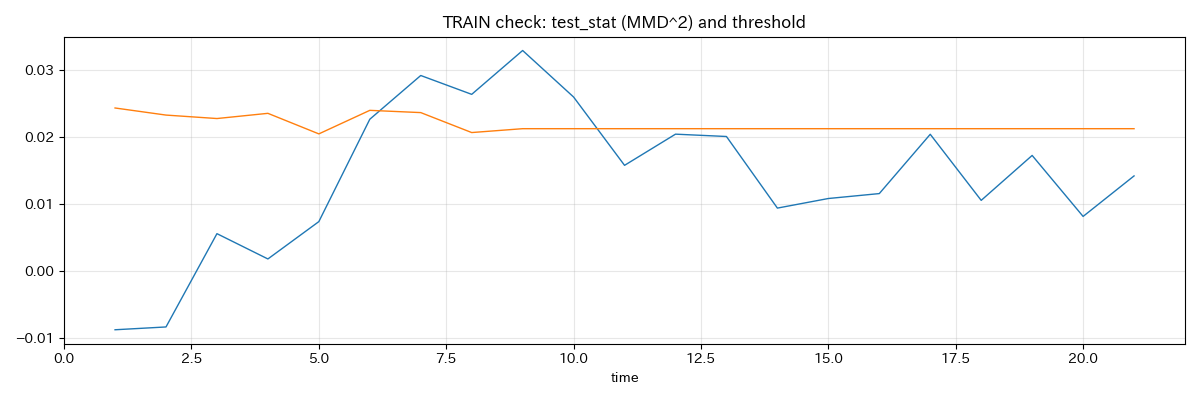

In [11]:

# ============================================================
# 共通：ストリームを流してログを取る関数
# ============================================================
def run_stream(detector, X_stream):
    records = []
    for t in range(X_stream.shape[0]):
        x_t = X_stream[t]  # (M,) 1サンプル（バッチ次元なし）
        preds = detector.predict(x_t, return_test_stat=True)
        d = preds["data"]
        records.append({
            "time": int(d["time"]),
            "is_drift": int(d["is_drift"]),
            "test_stat": float(d["test_stat"]),
            "threshold": float(d["threshold"])
        })
    return pd.DataFrame(records)

# ============================================================
# ⑤ 学習した結果を、学習データ（正常）で確認
#   - ここでは「参照に使っていない残りの正常」を流す
#   - test_stat <= threshold が多い（=誤検知が少ない）ことを確認
# ============================================================
X_train_holdout = X_train_std[n_ref:]  # 正常のまま
df_log_train = run_stream(cd, X_train_holdout)

ok_ratio = np.mean(df_log_train["test_stat"].values <= df_log_train["threshold"].values)
fa_rate  = np.mean(df_log_train["is_drift"].values == 1)
print(f"[TRAIN check] ratio(test_stat<=threshold)={ok_ratio:.3f}, false_alarm_rate={fa_rate:.3f}")

plt.figure(figsize=(12,4))
plt.plot(df_log_train["time"], df_log_train["test_stat"], linewidth=1.0)
plt.plot(df_log_train["time"], df_log_train["threshold"], linewidth=1.0)
plt.title("TRAIN check: test_stat (MMD^2) and threshold")
plt.xlabel("time")
plt.grid(True, alpha=0.3)
plt.tight_layout()


In [12]:

# ============================================================
# ⑥ テストデータで性能確認
#   - 状態だけリセット（閾値設定は保持）
#   - 正常→異常→正常→異常 の区間で is_drift が立つか見る
# ============================================================
cd.reset_state()

df_log_test = run_stream(cd, X_test_std)



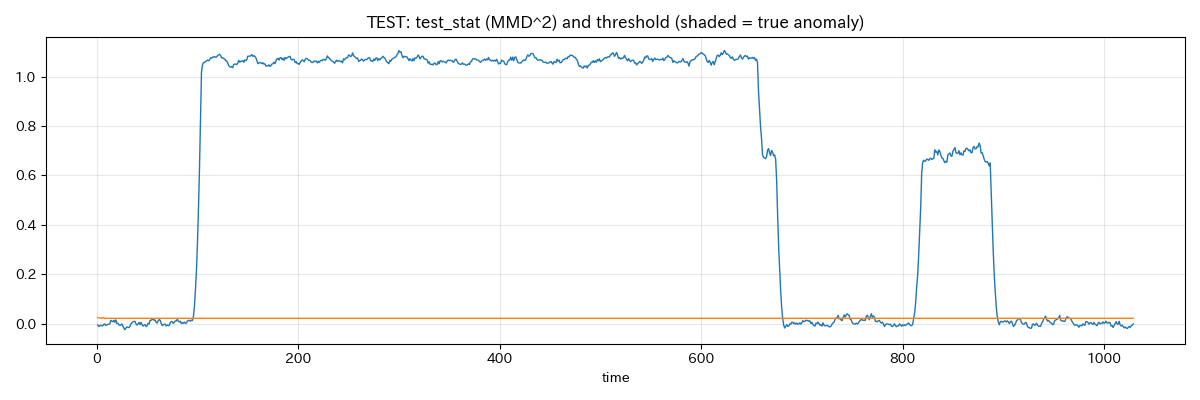

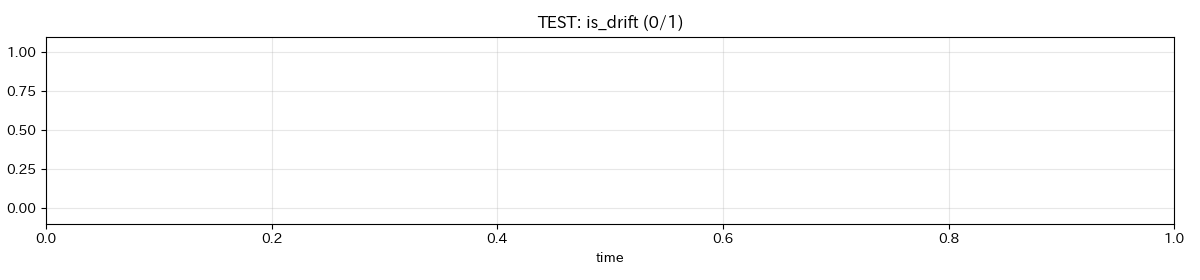

In [13]:


# 区間ごとの簡易集計
def segment_report(y_true, y_pred, name):
    mask = (y_true == 1) if name == "anom" else (y_true == 0)
    if mask.sum() == 0:
        return np.nan
    return y_pred[mask].mean()


# 可視化：test_stat と threshold、真の異常区間を背景に表示
plt.figure(figsize=(12,4))
plt.plot(df_log_test["time"], df_log_test["test_stat"], linewidth=1.0)
plt.plot(df_log_test["time"], df_log_test["threshold"], linewidth=1.0)
plt.title("TEST: test_stat (MMD^2) and threshold (shaded = true anomaly)")
plt.xlabel("time")
plt.grid(True, alpha=0.3)

# 背景（真の異常区間）
plt.tight_layout()

# driftフラグ自体も見たい場合（0/1の時系列）
plt.figure(figsize=(12,2.8))
plt.title("TEST: is_drift (0/1)")
plt.xlabel("time")
plt.ylim(-0.1, 1.1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
